# Deep Learning and Reinforcement Learning in Portfoio Management

**Abstract**

*Deep learning and reinforcement learning are highly sensitive to factors such as parameters and network structure. In this project, construct several simple deep learning models to predict the stock price movements, trading indicators and proportions in portfolio. Then place these indicators in a reinforcement learning model for  training.*

**Introduction**

The recent advance of deep learning has been many attempts to solve the portfolio management problem with deep learning techniques which are trying to predict the price movement for the next period based on the history prices. The performances of these algorithms depends highly on the degree of prediction accuracy given that the market is difficult to predict. However, portfolio management can also be considered as a multi-armed bandit problem where an agent makes decision on continually reallocating some resources into a number of different financial investment assets to maximize the return (Haugen, 2001). Once applying reinforcement learning on portfolio management, the problem becomes to how the agent allocates the resources and collects reward at the next step. The report of Jiang, Z., Xu, D. and Liang, J. points that one approaching methods is using  architectures such as Convolutional Neural Network (CNN) or Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) cell to predict action (a distribution denoting the allocation) instead of price trends (Jiang, Xu and Liang, 2017).

This project is trying to tackle this problem with stock daily data of the technology companies from *nasdaq.com*. Three main models are designed and implemented in the project. A Neural Network model to predict the price trend and use this as the indicator of sell/buy signal. A RNN model with different hyperparameters to predict the stock price in the next period. Fit these predicted price into another CNN model for predicting the stocks allocation in portfolio. Compare the performance of these methods.


In [1]:
# import data if using google colab
from google.colab import files
files.upload()

{}

### Assumptions

There are two basic assumptions on the behaviour of the stock market:
*   Negligible Market Impact: the action has minimum impact on the stock market. In other words, the stock prices are given as input data for the Reinforcement Learning should not be affected by the agent's actions.
*   Continuity Stock Unit: Instead of discrete shares,  assume that the agent can trade continues amount of shares (e.g., 10.5 shares). This can simplify the environment setting.


### Global Configuration Definition

**Introduce Dataset:** 
* Download the companies list from the Nasdaq website. Filter and keep the technology companies' tickers then fetch the stock daily information which is from January 1st 2010 to April 1st 2019, via *DataDownloader.py* with *yahoo! finance* API.
* *train_proportion*: 80% history data are used as training dataset and the rest most latest 20% data are testing dataset.

**Parameters**
* The variables defined in the config class are the constant global hyperparameters. This can avoid the redundancy in the following code.
* Example Tickers: The demo tickers in the project are: ["AAPL", "GOOG", "JOBS", "LOGI", "MSFT"]
* *seq_len & prediction_len*: previous 30 days (seq_len) historical prices which are used to predict the following 7 days (prediction_len) stock prices.
* *validation_split*: 10% data in the training dataset are used as validation dataset
* *normalize*: the indicator of data normalization
* *history*: the length of the historical stock price used for CNN model to predict the stock allocation


In [0]:
import pandas as pd

class config:

    # global
    raw_data = pd.read_csv("Stocks.csv", header=[0, 1], index_col=[0])
    tickers = ["AAPL", "GOOG", "JOBS", "LOGI", "MSFT"]  # select tickers

    # LSTM Model
    seq_len = 30  # history length
    prediction_len = 7  # prediction length
    train_proportion = 0.8  # ration of training data
    normalize = True

    learning_rate = 0.001
    RNN_epochs = 20
    batch = 16
    validation_split = 0.1
    
    # CNN Prediction
    NN_Epochs = 100

    # CNN Action Prediction
    history = 10
    n_stock = len(tickers)

    # Reinforcement Learning
    transaction_cost = 0.0002
    init_assets = 10000
    RL_episode = 50


** Plot the Learning Steps (Loss & Accuracy) **

In [0]:
def drawHist(data):
    """ Draw the learning step """
    
    fig = plt.figure(facecolor='white')
    fig, ax = plt.subplots(2, 1, figsize=(18, 8))
    
    ax[0].plot(data.loss, label="Loss")
    ax[0].set_title("LOSS")
    ax[0].legend()
    
    ax[1].plot(data.acc, label="Accuracy")
    ax[1].set_title("ACCURACY")
    ax[1].legend()
    
    plt.xlabel("Iteration")
    plt.suptitle("Learning Steps", fontsize=18)
    plt.show()

## Neural Network Model to Predict Stock Trend

> The financial data contain a large amount of noises, jump, and movement leading to the highly nonstationary time series. To mitigate data noise and uncertainty, handcraft financial features are usually extracted to summarize the market conditions (Neely et al., 2013). The search for ideal indicators foe the technical analysis has been extensively studied in quantitative finance.


In [0]:
# # uncomment if use IDE
# from config import config


# uncomment the following code if using google.colab

!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib
import talib

import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Dropout, Activation, Dropout
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

### Feature Explanations:

Use the stock daily Open, High, Low, Close (OHLC) prices and Volume information to contribute the stock daily features.

- **H-L**: the difference between the daily Highest price and the Lowest price
 
- **O-C**: the difference between the daily Open price and the Close price

- **K-L**: the difference between the daily Open price and the Close price divided by the difference between the daily Highest price and the Lowest price (O-L / H-L)

- **DI (Dispersion Index)**: Dispersion is a statistical term that describes the size of the range of values expected for a particular variable. In finance, dispersion is used in studying the effects of investor and analyst beliefs on securities trading, and in the study of the variability of returns from a particular trading strategy or investment portfolio. It is often interpreted as a measure of the degree of uncertainty and, thus, risk, associated with a particular security or investment portfolio.

- **3/10/30 day MA (3/10/30 days Moving Average)**: This is a statistical analysis methods for averaging the stock securities prices (index) in a certain period of time.

- **Std_dev**: Average variance within 5 days. It is another commonly used statistic for measuring dispersion. It is a simple way to measure an investment or portfolio's volatility. The lower the standard deviation, the lower the volatility. 

- **RSI (Relative Strength Index)**: The relative strength index (RSI) is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. It refers to the analysis of the market's intention and strength in buying the market by comparing the average closing gains and the average closing declines over a period of time, so as to make future market trends.

- **Williams %R**: A type of momentum indicator that moves between 0 and -100 and measures overbought and oversold levels. It is a technical analysis oscillator showing the current closing price in relation to the high and low of the past N days (N=7). It is an oscillatory indicator that measures whether the stock/index is overbought or oversold according to the swing point of the stock price. It measures the ratio of the peak (highest price) created by both long and short sides to the daily closing price and the range of stock price fluctuations within a certain period of time (such as 7 days) to provide a signal that the stock market trend reverses.

- **Price_Rise**: Define the output value as the stock price increase indicator, which is a binary variable that is either 1 or 0. If the closing day of the next day is higher than the closing price of the day, then assign it as 1.


In [0]:
def addFeature(dataset):
    """ add stock feature base on the dataset """

    dataset["H_L"] = dataset["High"] - dataset["Low"]
    dataset['O_C'] = dataset['Adj Close'] - dataset['Open']
    dataset["K_L"] = dataset['O_C'] / dataset["H_L"]
    dataset["DI"] = dataset["Volume"] * (dataset["Adj Close"] * 2 - dataset["High"] - dataset["Low"]) / dataset["H_L"]

    dataset['3day MA'] = dataset['Adj Close'].shift(1).rolling(window=3).mean()
    dataset['10day MA'] = dataset['Adj Close'].shift(
        1).rolling(window=10).mean()
    dataset['30day MA'] = dataset['Adj Close'].shift(
        1).rolling(window=30).mean()
    dataset['Std_dev'] = dataset['Adj Close'].rolling(5).std()

    dataset['RSI'] = talib.RSI(dataset['Adj Close'].values, timeperiod=9)
    dataset['Williams %R'] = talib.WILLR(dataset['High'].values, 
                                         dataset['Low'].values, 
                                         dataset['Adj Close'].values, 7)
    dataset['Price_Rise'] = np.where(
        dataset['Adj Close'].shift(-1) > dataset['Adj Close'], 1, 0)

    dataset = dataset.dropna()

    return dataset

### Construct Neural Network

Instantiate the deep learning model as a variable classifier whose output includes only one units because the goal is predicting the probability of stock market movements. Once get the predicted value of the stock price movement, the strategy model profit can be calculated.

In [0]:
def buildModel(n_feature=10):
    """ build neural network model """
    
    # Initialization
    model = Sequential()
    
    # 1st Dense & Dropout Layer
    model.add(Dense(units=64, 
                    kernel_initializer='uniform',
                    activation="relu",
                    input_dim=n_feature))
    model.add(Dropout(0.2))
    
    # 2nd Dense & Dropout Layer
    model.add(Dense(units=128,
                    kernel_initializer='uniform',
                    activation="relu"))
    model.add(Dropout(0.2))


    # Output layer
    model.add(Dense(units=1,
                    kernel_initializer='uniform',
                    activation='sigmoid'))
    
    # Compile layer
    model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['accuracy'])

    return model

### Split Dataset

**X & Y**:
* "X" and "y" stores the input and output variables. The data frame "X" stores the input characteristics, with columns starting from the 5th column (index 4) up to the second last column of the *stock_features* dataframe. The last column of the *stock_feature* dataframe is stored in the "y", which is the value that want to predict, which is the *price increase* indicator.

**Data Normalization**:
* Another important step in data pre-processing is data normalization which will ensure the model unbiased because of the differences in input characteristics when training the model. Without the normalization, the model might be confused if the larger inputs has larger weights. This can be implemented by importing the *StandardScaler* method from the *sklearn.preprocessing* library. Firstly, instantiat the variable *sc* with the *StandardScaler()* function and apply to the X_train and X_test dataset using *fit_transform* function. For the y_train and y_test dataset, since they are binary variables, it not necessary nomalize them.

**Cumulative Return**
* The policy here is if the predicted y is True, then make long trades, else make short trades. This is a very simple polity.


In [0]:
def stockPriceTrend():
    """ main function"""

    # Step 1. read data from csv and add features
    stock_features = addFeature(config.raw_data[config.tickers[0]])

    X = stock_features.iloc[:, 5:-1]  # features dataframe
    y = stock_features.iloc[:, -1]  # price change

    # Step 2. define training / testing datset
    split = int(len(stock_features) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    # Step 3. Data Normalization
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Step 4. Build Model
    model = buildModel()
    trend_hist = model.fit(X_train, y_train, batch_size=32, 
                           epochs=config.NN_Epochs, verbose=False)

    # Step 5. Predict Stock Trend
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5)

    stock_features['y_pred'] = np.NaN
    stock_features.iloc[(len(stock_features) - len(y_pred)):, -1:] = y_pred
    stock_features = stock_features.dropna()

    # Step 6. Cummulative Trturn 
    stock_features['Tomorrows Returns'] = 0.
    stock_features['Tomorrows Returns'] = np.log(
        stock_features['Adj Close'] / stock_features['Adj Close'].shift(1))
    stock_features['Tomorrows Returns'] = stock_features['Tomorrows Returns'].shift(
        -1)

    stock_features['Strategy Returns'] = 0.
    stock_features['Strategy Returns'] = np.where(stock_features['y_pred'] == True,
                                                  stock_features['Tomorrows Returns'],
                                                  - stock_features['Tomorrows Returns'])

    stock_features['Cumulative Market Returns'] = np.cumsum(
        stock_features['Tomorrows Returns'])
    stock_features['Cumulative Strategy Returns'] = np.cumsum(
        stock_features['Strategy Returns'])
    
    return stock_features, trend_hist

In [0]:
# Run Neural Network Model: Predict cummulative return
cummulative_rt, trend_hist = stockPriceTrend()

<Figure size 432x288 with 0 Axes>

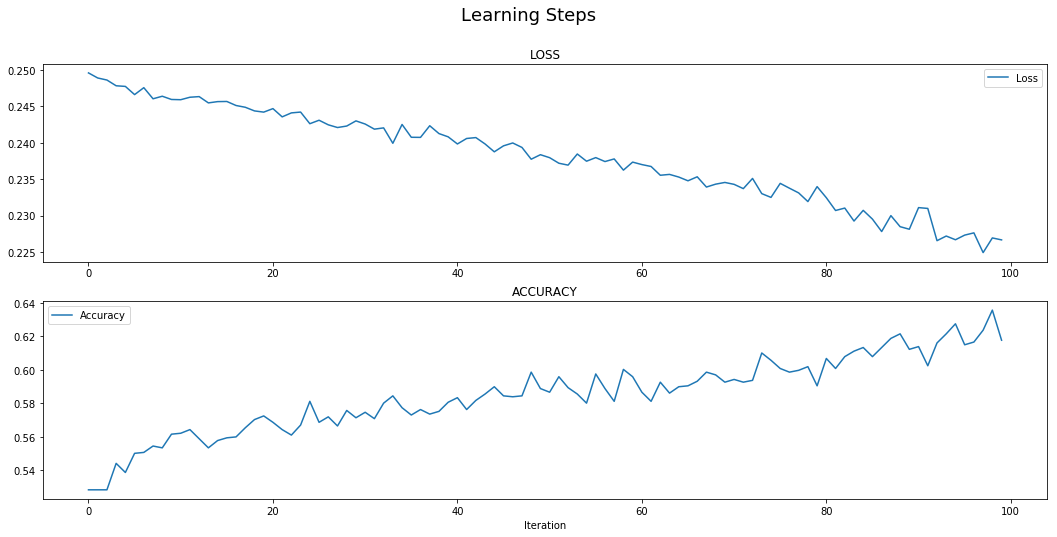

In [9]:
# Step 7. Plot learning steps
drawHist(pd.DataFrame(trend_hist.history))

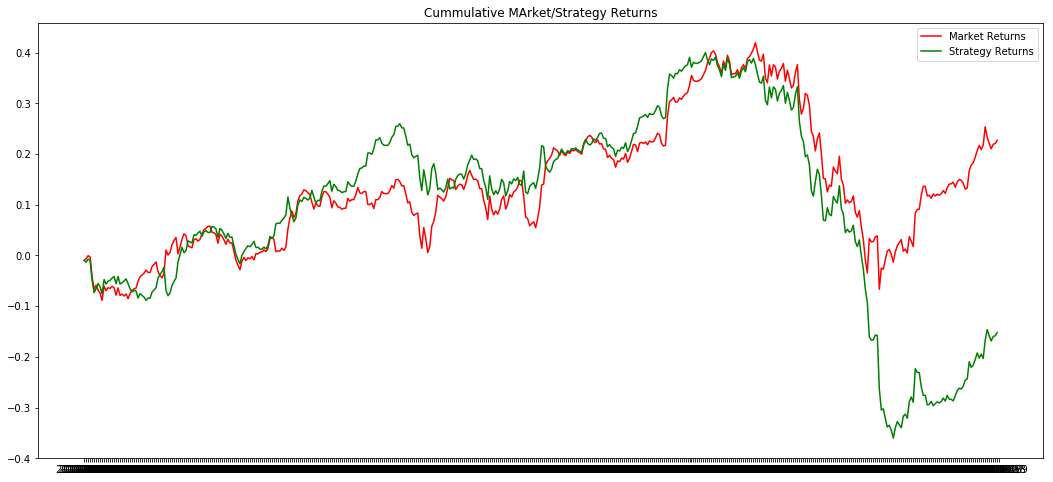

In [10]:
# Step 8. Plot the summulative profit 
plt.figure(figsize=(18, 8))
plt.plot(cummulative_rt['Cumulative Market Returns'],
         color='r', label='Market Returns')
plt.plot(cummulative_rt['Cumulative Strategy Returns'],
         color='g', label='Strategy Returns')
plt.title("Cummulative MArket/Strategy Returns")
plt.legend()
plt.show()

### Summary: 

In this part, a simple model is learned for stock trading, which basically based on daily stock prices. However, the reality can be much more complicated. If the data is sufficient, not only the number of the data but also the data dimension, and more training times, the performance of the neural network can be further improved. If a more complex trading model needed, the stock data refined to every minute can be used, so that the training effect of the model might be more efficient.


## LSTM Model to Predict the Stock Price

One of the fundamental problems which plagued traditional neural network architectures for a long time was the ability to interpret sequences of inputs which relied on each other for information and context. Simply put, traditional neural networks take in a stand-alone data vector each time and have no concept of memory to help them on tasks that need memory. LSTM (Long Short Term Memory) is a special type of RNN that makes it easier to learn from long-term dependencies compared to other RNNs, therefore, many researchers try to apply it on time series prediction problems. With the idea of Aungiers, a stock market time series is not any sort of specific static function which can be mapped. The best property to describe the motion of a stock market time series would be a random walk (Aungiers, 2018). Construct a RNN model for predicting the stock price.


In [0]:
# # uncomment if using IDE
# from config import config 

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras import optimizers
from numpy import newaxis

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import itertools

### Data Normalization

Normalization is still necessary since the stock price is a constantly moving absolute price of the stock market. If training the model without normalizing data, it never converge.
* Normalization: $n_i=\left(\frac{p_i}{p_0}\right)-1$
* Denormalizatoin: $p_i = p_0(n_i + 1)$

where *n = normalized list [window] of price changes, p = raw list [window] of adjusted daily return prices*


In [0]:
def Normalizatoin(data_slice):
    """ Data Normalization """

    dataNormalized = []
    for slice in data_slice:
        normalized_slice = [(p / slice[0]) - 1 for p in slice]
        dataNormalized.append(normalized_slice)
    return dataNormalized

In [0]:
def Denormalization(data_norm, data):
    """ Data Denormalization """

    dataDenormalized = []
    wholelen = 0
    for i, rowdata in enumerate(data_norm):
        denormalize = []

        if isinstance(rowdata, float) | isinstance(rowdata, np.float32):
            denormalize = [(rowdata + 1) * float(data[wholelen][0])]
            dataDenormalized.append(denormalize)
            wholelen += 1
        else:
            for j in range(len(rowdata)):
                denormalize.append((rowdata[j] + 1) * data[wholelen][0])
                wholelen += 1
            dataDenormalized.append(denormalize)
    return dataDenormalized

In [0]:
def LSTM_load_data(ticker, normalize=True):
    """ load data from a csv. file, return training and testing dataset """

    # Step 1. select stock daily Adj. Closed price
    daily_price = config.raw_data[ticker]

    dates = list(daily_price.index)
    closeData = list(daily_price["Adj Close"])
    seq_len = config.seq_len + 1

    # Step 2. data normalize
    data_segment, date_segment = [], []
    for i in range(len(closeData) - seq_len):
        data_segment.append(closeData[i: i + seq_len])
        date_segment.append(dates[i: i + seq_len])
    norm_data = Normalizatoin(data_segment) if normalize else data_segment

    data_segment = np.array(data_segment)
    date_segment = np.array(date_segment)
    norm_data = np.array(norm_data)

    # Step 3. separate the data into training and testing set
    row = round(config.train_proportion * norm_data.shape[0])
    dates_train = date_segment[: row, :]
    train = norm_data[: row, :]
    np.random.shuffle(train)

    x_train, y_train = train[:, : -1], train[:, -1]
    x_tr_date, y_tr_date = dates_train[:, : -1], dates_train[:, -1]

    x_test, y_test = norm_data[row:, :-1], norm_data[row:, -1]
    x_te_date, y_te_date = date_segment[row:, :-1], date_segment[row:, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

    # Step 4. define test data
    test_data = data_segment[row:, :]

    return x_train, y_train, x_test, y_test, y_te_date, test_data

In [0]:
def RNN_LSTM():
    """ Build a Long Short-Term Model """

    # initialize model
    model = Sequential()

    # 1st LSTM & Dropout layer
    model.add(LSTM(input_shape=(None, 1),
                   units=config.seq_len,
                   return_sequences=True))
    model.add(Dropout(0.2))

    # 2nd LSTM & Dropout layer
    model.add(LSTM(units=100, return_sequences=False))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(units=1))
    model.add(Activation("linear"))

    # optimizer
    opt = optimizers.RMSprop(lr=config.learning_rate, rho=0.9, epsilon=1e-06)

    # compile model
    model.compile(loss="mean_squared_error", optimizer=opt)

    return model

In [0]:
def predict_point_by_point(model, data):
    """ predict one step at a time """

    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size))
    return predicted

In [0]:
def predict_sequence_full(model, data):
    """ Gradually predict the entire time series based on the training model and
        the length of the time series used for prediction in the first segment """

    curr_frame = data[0]
    predicted = []

    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[newaxis, :, :])[0, 0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(
            curr_frame, [config.seq_len - 1], predicted[-1], axis=0)

    return predicted

In [0]:
def predict_sequences_multiple(model, data):
    """ A sequence that predicts the length of the prediction_len step by step based on the training model
        and the length of the time series used to predict each segment """

    prediction_seqs = []
    for i in range(int(len(data) / config.prediction_len)):
        curr_frame = data[i * config.prediction_len]

        predicted = []
        for j in range(config.prediction_len):
            predicted.append(model.predict(curr_frame[newaxis, :, :])[0, 0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [config.seq_len - 1],
                                   predicted[-1], axis=0)
        prediction_seqs.append(predicted)

    return prediction_seqs

In [0]:
def LSTM_main(ticker):
    """ main function of the LSTM Model """

    # Step 1. build training and testing data
    X_train, y_train, X_test, y_test, date_test, data_test = LSTM_load_data(ticker)

    # Step 2. build model
    model = RNN_LSTM()

    # Step 3. train model
    model.fit(X_train, y_train,
              batch_size=config.batch,
              epochs=config.RNN_epochs,
              validation_split=config.validation_split,
              verbose=False)

    # Step 4. stock price prediction
    y_pred_pt = predict_point_by_point(model, X_test)
    y_pred_seq = predict_sequence_full(model, X_test)
    y_pred_multi = predict_sequences_multiple(model, X_test)

    # Step 5. denormalize data
    if config.normalize:
        y_hat_pt = Denormalization(y_pred_pt, data_test)
        y_hat_seq = Denormalization(y_pred_seq, data_test)
        y_hat_multi = Denormalization(y_pred_multi, data_test)
        y_test = Denormalization(y_test, data_test)

    return y_hat_pt, y_hat_seq, y_hat_multi, y_test, date_test

In [0]:
def mixed_Predicted_Price():
    """ rearrange all the selected stocks predicted price """

    y_true = [[] for _ in config.tickers]
    pt_, seq_, multi_ = y_true.copy(), y_true.copy(), y_true.copy()
    pt_df, seq_df, multi_df = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    for i, ticker in enumerate(config.tickers):
        pt_[i], seq_[i], multi_[i], y_true[i], date_test = LSTM_main(ticker)

        # unstack the list
        pt_df[ticker] = list(itertools.chain(*pt_[i]))
        seq_df[ticker] = list(itertools.chain(*seq_[i]))
        multi_df[ticker] = list(itertools.chain(*multi_[i]))

    pt_df.index = date_test
    seq_df.index = date_test
    multi_df.index = date_test[:-4]

    return pt_, seq_, multi_, pt_df, seq_df, multi_df, y_true

In [0]:
# Run LSTM Model: Stock Price Prediction
pt_, seq_, multi_, pt_df, seq_df, multi_df, y_true = mixed_Predicted_Price()

In [0]:
def plot_result(pt, seq, multi, true_data, ticker):
    """ plot the predicted and true data """

    fig = plt.figure(facecolor='white')
    fig, ax = plt.subplots(2, figsize=(18, 8))

    ax[0].plot(true_data, label='True Data')
    ax[0].plot(pt, label='Predict one step at a time')
    ax[0].plot(seq, label='Predict entire time series')
    ax[0].legend()

    ax[1].plot(true_data, label='True Data')
    for i, data in enumerate(multi):
        padding = [None for p in range(i * config.prediction_len)]
        ax[1].plot(padding + data)
    ax[1].legend()

    plt.suptitle(
        "Compare the Predicted Stock Price (%s) with the True Price" % ticker, fontsize=18)
    plt.show()

### Plot the Predicted Stock Price & True Price

<Figure size 432x288 with 0 Axes>

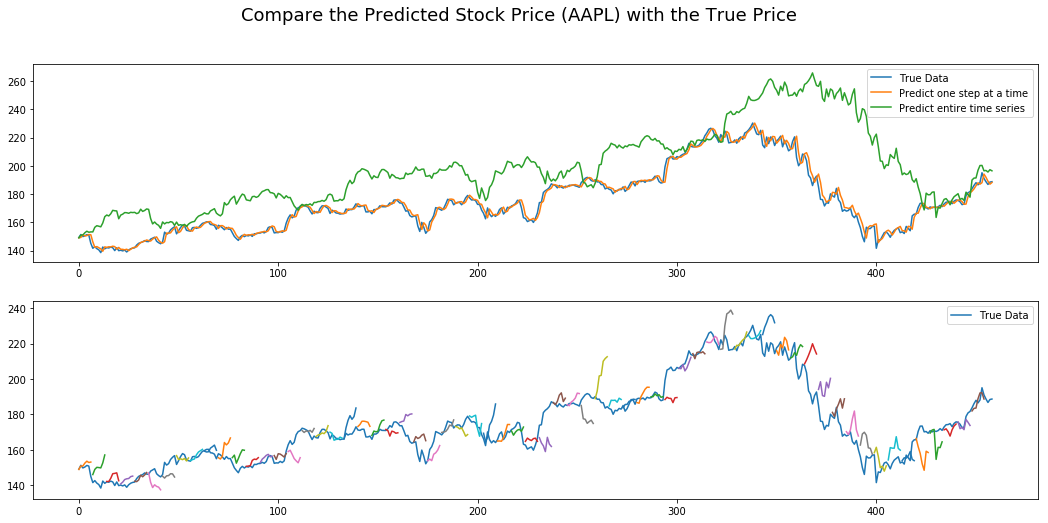

In [23]:
plot_result(pt_[0], seq_[0], multi_[0], y_true[0], config.tickers[0])

<Figure size 432x288 with 0 Axes>

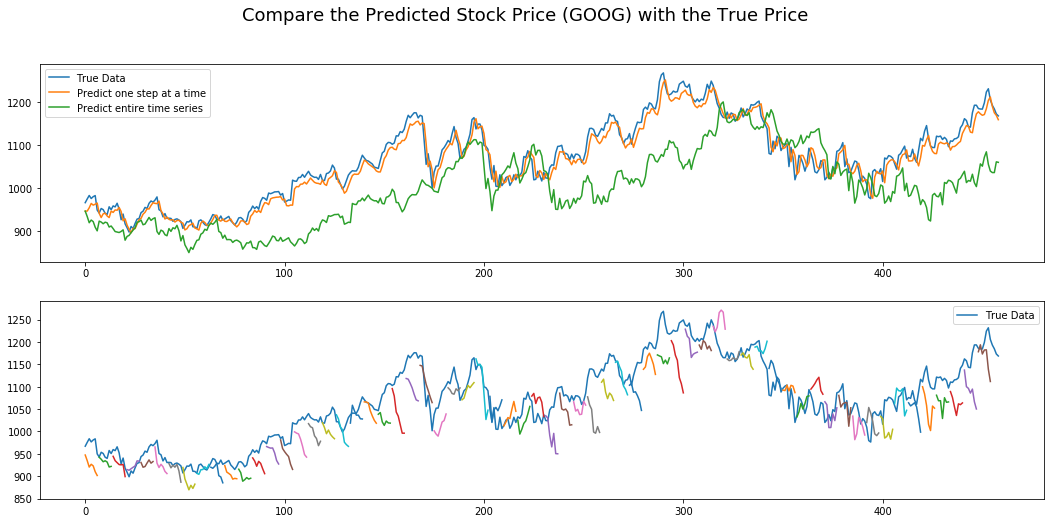

In [24]:
plot_result(pt_[1], seq_[1], multi_[1], y_true[1], config.tickers[1])

<Figure size 432x288 with 0 Axes>

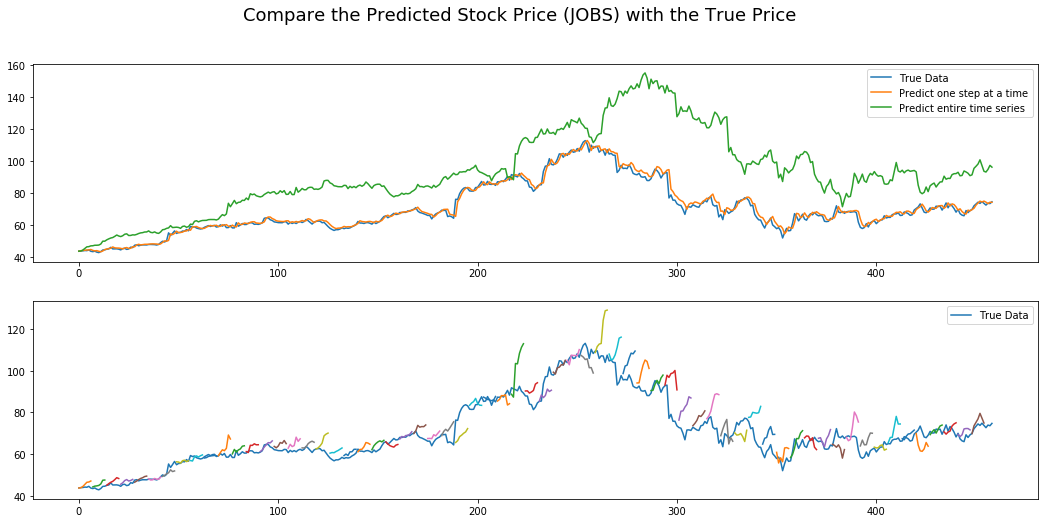

In [25]:
plot_result(pt_[2], seq_[2], multi_[2], y_true[2], config.tickers[2])

<Figure size 432x288 with 0 Axes>

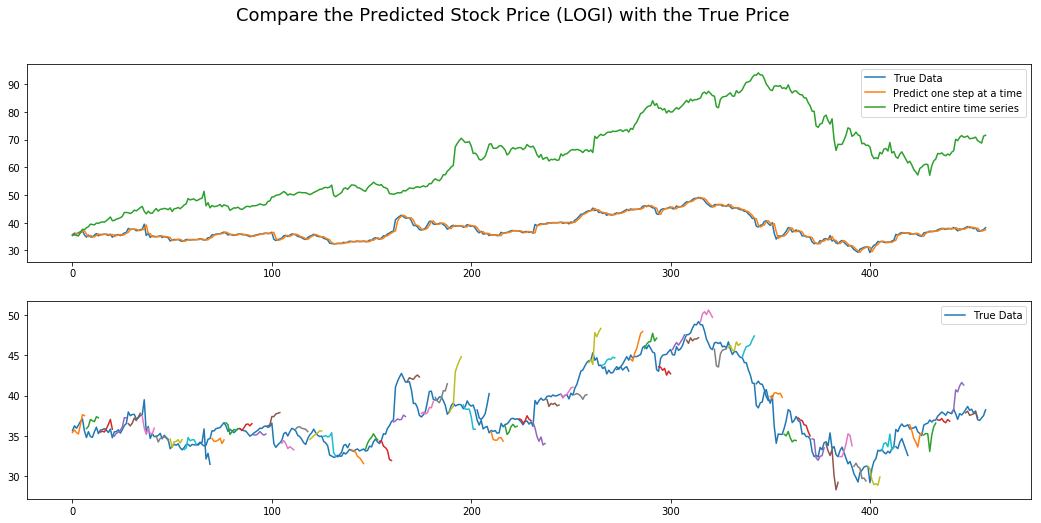

In [26]:
plot_result(pt_[3], seq_[3], multi_[3], y_true[3], config.tickers[3])

<Figure size 432x288 with 0 Axes>

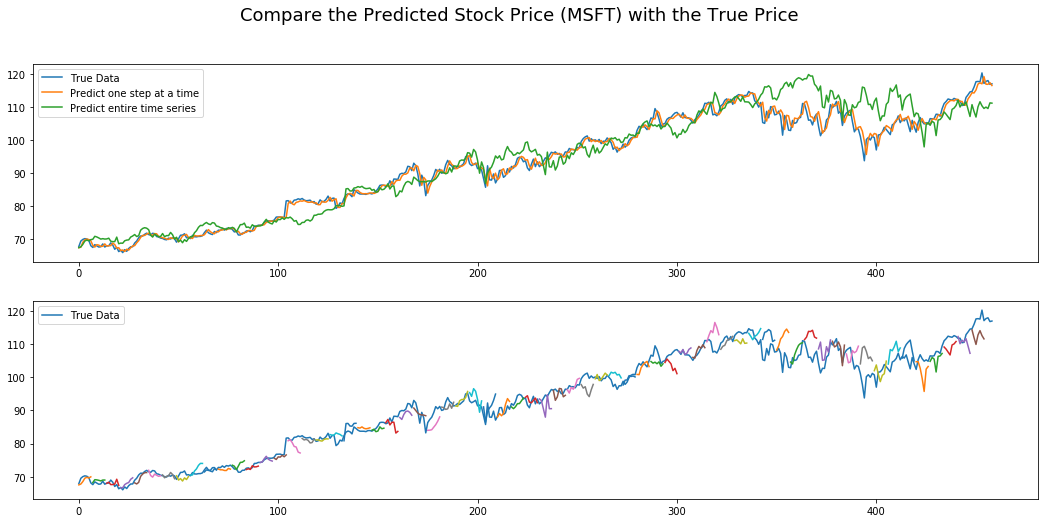

In [27]:
plot_result(pt_[4], seq_[4], multi_[4], y_true[4], config.tickers[4])

### Summary:

**Point by Point Prediction**

The single point-by-point prediction seems can match the returns perfectly. But look closely, the prediction line always lags behind the true stock price. This is because the prediction line is made up of singular prediction points that have had the whole prior true history window behind them. Therefore, even if the previous predicted point wrong, the next prediction won't be affected by that too much.
 

**Full Sequence Prediction**

The full sequence prediction it seems like this proves to be the least useful prediction for this type of time series, at least trained on this model with these hyperparameters. Its performance is extremely unstable. Even in the first few days, the stock price cannot be predicted very well.

**Multi-Sequence Prediction**

This is a blend of the full sequence prediction in the sense that it still initializes the testing window with test data, predicts the next point over that and makes a new window with the next point. However, once it reaches a point where the input window is made up fully of past predictions it stops, shifts forward one full window length, resets the window with the true test data, and starts the process again. In essence this gives multiple trend-line like predictions over the test data to be able to analyse how well the model can pick up future momentum trends (Aungiers, 2018). Again, this method is still sensitive on the hyperparameters and the dataset. In some dataset, its prediction can match the trend of the stock price, but some of the predicted results are far from reality. The improvement over the pure full sequence method is that it can always back to the reality periodically.

Overall, this LSTM model is a single dimensional model using the *Adj Close* price only. A more complex LSTM model can training with higher dimension data in order to enhance the accuracy of our model. As of now however, LSTMs provide significant advancements on more classical statistical time series approaches.


## CNN Model to Predict Stock Proportion

Instead of using the deep learning model to predict the stock price, we use the CNN model to learn how to allocate the stock in a portfolio. The output of the model indicate the proportion of the corresponding stock in the portfolio. Hence, intuitively, stocks with better trends in the future should account for a larger proportion of the portfolio. In addition, the summation of the weight for each stock should be one. Therefore, use another function to normalized the data. The output will pass to the reinforcement learning model for assets prediction. The test datasets are the predicted stock prices from LSTM model.

In [0]:
# # uncomment if using IDE
# import LSTM_Model
# from config import config 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from keras.models import Sequential
from keras.layers.convolutional import Conv2D, AveragePooling2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.regularizers import l2
from sklearn.preprocessing import StandardScaler

In [0]:
def CNN_Act_load_data(dataset, train):
    """ load stock data """

    if train:
        daily_close = pd.DataFrame(index=dataset.index)

        for ticker in config.tickers:
            daily_close[ticker] = dataset[ticker]["Adj Close"]
    else:
      daily_close = dataset
    daily_lrt = np.log(1 + daily_close.pct_change().dropna())

    # separate the date by history legth
    train_num = daily_lrt.shape[0] - config.history + 1
    X = np.empty((train_num, config.history, config.n_stock))
    Y = np.array(daily_lrt[:train_num])
    Y[Y < 0] = 0
    for i in range(train_num):
        X[i] = daily_lrt.iloc[i:config.history + i].values
        # portfolio percentage
        Y[i] = np.zeros(5) if (Y[i] <= 0).all() else np.true_divide(
            Y[i], Y[i].sum(keepdims=True))

    daily_close_train = daily_close[:train_num]

    return X, Y, daily_close_train

In [0]:
def CNN_Action():
    """ build CNN Model: predict the stock proportion in th portfolio"""

    model = Sequential()

    # 1st CNN & Dropout layer
    model.add(Conv2D(filters=10, kernel_size=2,
                     input_shape=(config.history, config.n_stock, 1),
                     strides=(1, 1), padding="same", activation="relu"))
    model.add(AveragePooling2D(pool_size=(1, 1), strides=1))
    model.add(Dropout(0.2))

    # 2nd CNN & Dropout layer
    model.add(Conv2D(filters=64, kernel_size=2,
                     strides=(1, 1), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 1), strides=2))
    model.add(Dropout(0.2))

    # 3rd CNN & Dropout layer
    model.add(Conv2D(filters=config.n_stock, kernel_size=2,
                     strides=(1, 1), padding="same", activation="relu"))
    model.add(Dropout(0.2))

    # output layer
    model.add(Flatten())
    model.add(Dense(units=config.n_stock,
                    kernel_initializer="he_normal",
                    kernel_regularizer=l2(0.001)))
    model.add(Activation("softmax"))

    # compile model
    model.compile(optimizer="adam", loss="mean_squared_error",
                  metrics=["accuracy"])

    return model

In [0]:
def actionPrediction(pred_df):

    # Step 1. load training data
    dataset = config.raw_data[config.tickers]
    X, Y, daily_close = CNN_Act_load_data(dataset, True)
    x_test, y_test, _ = CNN_Act_load_data(pred_df, False)

    # define the training & testing dates
    dates = np.array(dataset.index)
    _, _, _, _, date_test, _ = LSTM_load_data(config.tickers[0])
    date_train = np.setdiff1d(dates, date_test, assume_unique=True)

    daily_close_train = daily_close[:date_train.shape[0]]
    daily_close_test = daily_close[date_train.shape[0]:]

    x_train, y_train = X[:date_train.shape[0]], Y[:date_train.shape[0]]
    x_test, y_test = X[date_train.shape[0]:], Y[date_train.shape[0]:]

    # Step 3. build model
    model = CNN_Action()

    # Step 4. fit model
    x_train = np.reshape(x_train, [x_train.shape[0], x_train.shape[1],
                                   x_train.shape[2], 1])
    hist = model.fit(x_train, y_train, batch_size=8, 
                     epochs=config.NN_Epochs, verbose=False)

    # Step 5. predict
    x_test = np.reshape(x_test, [x_test.shape[0], x_test.shape[1],
                                 x_test.shape[2], 1])
    y_pred = model.predict(x_test)
    
    # Step 6. Plot the learning step
    drawHist(pd.DataFrame(hist.history))

    return y_pred, daily_close_test

<Figure size 432x288 with 0 Axes>

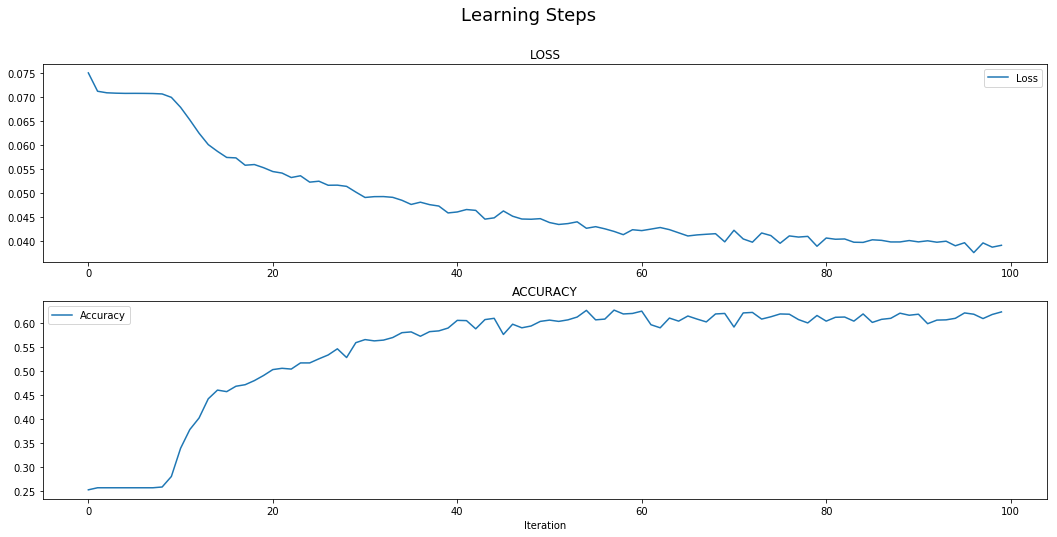

In [32]:
# Run CNN Model: Compute Stock Proportion
y_pred_pt, daily_close_test = actionPrediction(pt_df)

<Figure size 432x288 with 0 Axes>

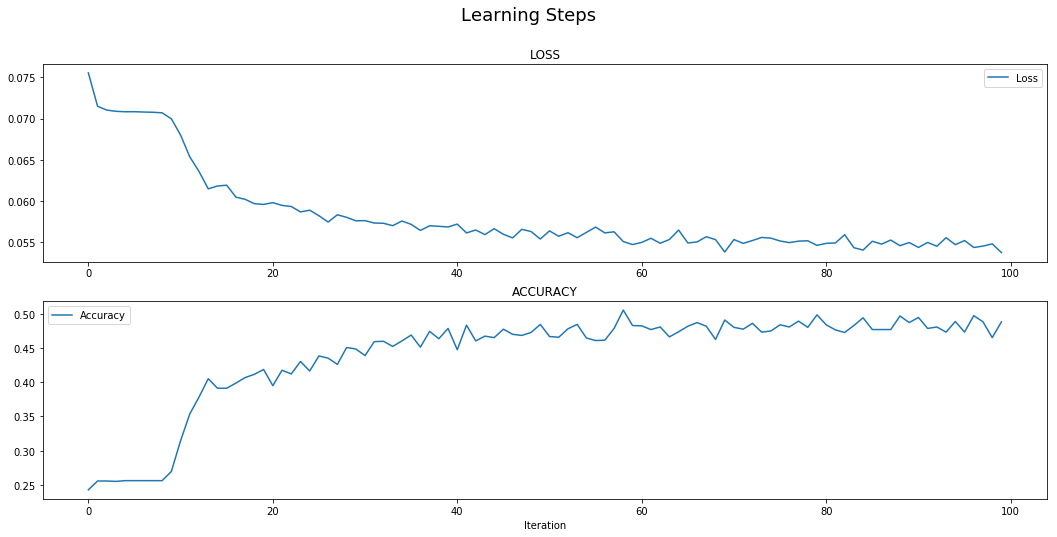

In [33]:
y_pred_multi, daily_close_test = actionPrediction(multi_df)

## Reinforcement Learning in Portfolio Management

The challenge stems from the difficulties in financial environment summarization and presentation(Murphy, 1999). Financial markets are easily affected by various factors, such as political factors, social topics, moral factors, unpredictable factors and the impact of different companies on the same production line will spread to each other.
 
Another non-negligible difficulty is the behaviour of trading action execution (Deng et al., 2016). Frequent trading in the short term does not necessarily yield revenue, as the costs incurred between transactions will reduce the profit.

In this project, the main objective is to combine deep learning and reinforcement learning in the implementation of stock strategies. The environment of stock trading draws some ideas from Zhan but simplified (Zhan, He and Li, 2017).
* State: $S^k=(S^k_1, S^k_1, ..., S^k_L)$. A state contains historical stock prices. $L$ is the stock number (5 in this project) in the portfolio. Limit the portfolio management action only happens at discrete time steps, at the end of each reading day.
* Portfolio: $P^k=(S^k_0, S^k_1, ..., S^k_L)$ where $\sum^L_{i=0}P^k_i=1$.
* Stock Allocation: The percentage generate by CNN Acttion Prediction Model.
* Actions: Only two actions can be Buy or Hold. Buy means reallocate the weights of each stock in the portfolio and Hold is keep the previous portfolio.
* Rewards: Define the reward as the profit at each stage. Profit is the total assets of the previous day minus the total assets of today. If the portfolio is operated, the cost of the stock transaction needs to be subtracted.
* Action Policy: Select the action by applying the epsilon-greedy-algorithm.

In [0]:
# # uncomment if using IDE
# from config import config
# from CNN_ActionPrediction import actionPrediction
# from LSTM_Model import mixed_Predicted_Price

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Action (Proportion) & Price prediction

In [0]:
# # uncomment if using IDE
# stock_proportion, stock_price = actionPrediction() 
# _, _, _, pt_pred, seq_pred, multi_df, _ = mixed_Predicted_Price()

# uncomment if using colab
stock_proportion, stock_price = y_pred_pt, daily_close_test # pt_pred
# stock_proportion, stock_price = y_pred_multi, daily_close_test # multi_pred

# price prediction
pt_pred,multi_df = pt_df, multi_df
pt_pred = pt_pred[pt_pred.index.isin(stock_price.index)]
multi_pred = multi_df[multi_df.index.isin(stock_price.index)]


# first day stock price
init_price = stock_price.iloc[0].values  

start_date = 0
final_date = stock_price.shape[0] - 1

In [0]:
class Environment():
    """ define the stock exchange environment """

    def __init__(self):
        """ Initialize the environment """

        self.init_price = init_price
        self.curr_price = self.init_price

        self.init_assets = config.init_assets
        self.curr_assets = self.init_assets

        self.init_proportion = np.array(
            [1 / config.n_stock for _ in config.tickers])
        self.curr_proportion = self.init_proportion

        self.init_share = config.init_assets * self.init_proportion / init_price
        self.curr_share = self.init_share

        self.reward = 0.0
        self.init_timestep = start_date
        self.timestep = self.init_timestep

        self.terminal = (final_date or self.curr_assets <= 0)
        self.is_done = False

    def reset(self):
        """ Reset the game environmet """

        self.curr_price = self.init_price
        self.curr_assets = self.init_assets
        self.curr_proportion = self.init_proportion
        self.curr_share = self.init_share

        self.reward = 0.0
        self.timestep = self.init_timestep
        self.is_done = False

        return self.timestep

    def step(self, action):  # hold or buy
        """ update after take an action """

        curr_price = self.curr_price
        curr_prop = self.curr_proportion
        curr_assets = self.curr_assets
        curr_share = self.curr_share

        pred_prop = stock_proportion[self.timestep + 1]

        # uncomment one price prediction code
        pred_price = pt_pred.iloc[self.timestep + 1].values
        # pred_price = multi_pred.iloc[self.timestep + 1].values

        if not action:
            cost = 0
            self.curr_assets = np.sum(curr_share * curr_price)
            self.curr_share = curr_share

        else:
            self.curr_assets = np.sum(curr_share * curr_price)
            cost = config.transaction_cost * self.curr_assets
            self.curr_share = self.curr_assets * pred_prop / pred_price

        price_change = (pred_price - curr_price)
        profit = np.sum(curr_assets * price_change) - cost

        self.curr_price = stock_price.iloc[self.timestep].values
        self.reward = profit
        self.is_done = (self.timestep + 1 == final_date)
        self.timestep += 1

        return self.timestep, self.curr_price, self.curr_assets, self.reward, self.is_done

In [0]:
def greedy_policy(q_values, epsilon=0.2):
    """ choose the action generated by CNN model """
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice([0, 1])
    else:
        return np.random.choice([action_ for action_, value_ in enumerate(
            q_values) if value_ == np.max(q_values)])

    return act_

In [0]:
def Sarsa(qsa, next_qsa, r, alpha=0.1, gamma=1.0):
    return qsa + alpha * (r + gamma * next_qsa - qsa)

In [0]:
def RL_main():
    """ reinforcement learning main function """

    env = Environment()
    sqa = np.zeros((1, 1, 2))
    assets = [[] for _ in range(config.RL_episode)]

    for epi in range(config.RL_episode):
        ts = env.reset()
        is_done = False

        # a_ = greedy_policy(sqa[0, ts, :])
        a_ = greedy_policy(sqa[0, 0, :])

        while not is_done:
            ts_, p_, ass_, r_, is_done = env.step(a_)
            assets[epi].append(ass_)

            # choose an action for the next start
            a_n = greedy_policy(sqa[0, 0, :])

            # Sarsa update
            sqa[0, 0, a_] = Sarsa(sqa[0, 0, a_], sqa[0, 0, a_n], r_)

            ts = ts_
            a_ = a_n

    return assets

In [0]:
# Run RL: for assect predictoin with pt_pred
pt_assets = RL_main()

In [0]:
# Run RL: for assect predictoin with multi_pred
multi_assets = RL_main()

In [0]:
assets_pd = pd.DataFrame([np.mean(np.array(pt_assets), axis=0), 
                          np.mean(np.array(multi_assets), axis=0)],
                          index=["pt_pred", "multi_pred"],
                          columns = pt_pred.index[:-1]).T

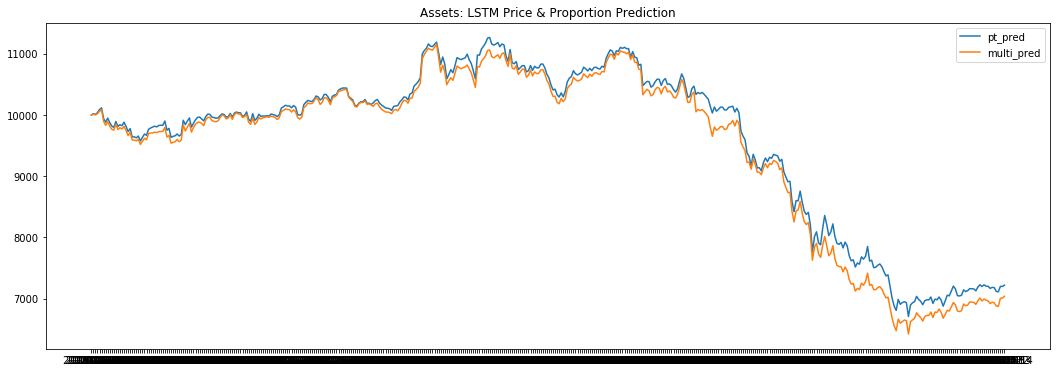

In [43]:
# plot the assets
plt.figure(figsize=(18, 6))
plt.plot(assets_pd)
plt.legend(labels=assets_pd.columns)
plt.title("Assets: LSTM Price & Proportion Prediction")
plt.show()

### Summary:

Based on the plot above, the model performance is not satisfied. There are several reasons:
* No matter which model, they contain more or less randomness. The LSTM model includes a large number of random factors in the training process, such as the training dataset are shuffled during the training. Similar reason in CNN model, the instability of the result itself will eventually lead to a deviation from the final result. In reinforcement learning model, the action selecting process adds the randomness factor.
* Too simple stock trading environment. Because the real stock trading environment is difficult to be well defined here, this can also be another excuse for the disappointed result.
* Last but not least, maybe it's the most significant reason, the stock features and the hyperparameters are not good enough.
 


**Reference**

Aungiers, J. (2018). Time Series Prediction Using LSTM Deep Neural Networks. [online] Altumintelligence.com. Available at: https://www.altumintelligence.com/articles/a/Time-Series-Prediction-Using-LSTM-Deep-Neural-Networks [Accessed 20 Apr. 2019].

Deng, Y., Bao, F., Kong, Y., Ren, Z. and Dai, Q. (2016). Deep Direct Reinforcement Learning for Financial Signal Representation and Trading. [online] Cslt.org. Available at: http://www.cslt.org/mediawiki/images/a/aa/07407387.pdf [Accessed 28 Apr. 2019].

Haugen, R. (2001). Modern investment theory. Upper Saddle River, N.J.: Prentice Hall.

Heaton, J., Polson, N. and Witte, J. (2019). Deep Learning in Finance. [online] Arxiv.org. Available at: https://arxiv.org/pdf/1602.06561.pdf [Accessed 5 Apr. 2019].

Jiang, Z., Xu, D. and Liang, J. (2017). A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem. [online] arXiv.org. 
Available at: https://arxiv.org/abs/1706.10059 [Accessed 28 Apr. 2019].

Neely, C., Rapach, D., Tu, J. and Zhou, G. (2013). Forecasting the Equity Risk Premium: The Role of Technical Indicators. [online] Citeseerx.ist.psu.edu. Available at: http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.431.994&rep=rep1&type=pdf [Accessed 28 Apr. 2019].

Murphy, J. (1999). Technical analysis of the financial markets. New York: New York Institute of Finance.

Zhan, R., He, T. and Li, Y. (2017). [online] Ruohanzhan.github.io. Available at: https://ruohanzhan.github.io/fun_proj/trading/report.pdf [Accessed 28 Apr. 2019].

